<a href="https://colab.research.google.com/github/rasecresende/CS146/blob/main/final_co2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Processing

In [1]:
# uploading data
# I deleted all of the text in the file, leaving only the numerical values
from google.colab import files 
uploaded = files.upload()

Saving weekly_in_situ_co2_mlo.csv to weekly_in_situ_co2_mlo (1).csv


In [2]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pystan
import scipy.stats as sts
import io
import datetime
import seaborn as sns
sns.set()

In [3]:
# load dataframe
df = pd.read_csv(io.BytesIO(uploaded['weekly_in_situ_co2_mlo.csv']))

# add headers
df.columns = ['Date', 'CO2']

# converts to datetime format
df.Date = pd.to_datetime(df['Date'])

# add weekly time column
weekly_time = []
for i in range(len(df.Date)):
   conversion = (df.Date[i] - df.Date[0]).days / 365.25
   weekly_time.append(conversion)

df['time'] = weekly_time

df.head()

,Date,CO2,time
0,1958-04-05,317.31,0.000000
1,1958-04-12,317.69,0.019165
2,1958-04-19,317.58,0.038330
3,1958-04-26,316.48,0.057495
4,1958-05-03,316.95,0.076660


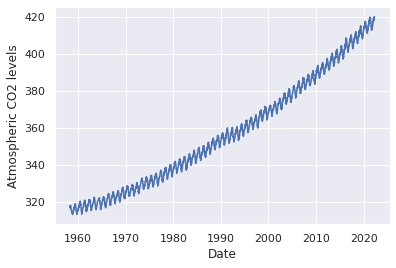

In [4]:
# Plotting dataset 
plt.figure()
plt.plot(df.Date, df.CO2)
plt.xlabel("Date")
plt.ylabel('Atmospheric CO2 levels')
plt.savefig('fig1.png')
plt.show()

# Long Term Trend - Linear Model



In [5]:
stan_code1 = """
data {
    int<lower=0> len_data;             
    real<lower=0> date[len_data];      
    real measurements[len_data];               
}

parameters {
    real<lower=0> c0;  
    real<lower=0> c1;  
    real<lower=0> c2;       
} 

model {
 
    // Priors
    c0 ~ normal(310, 20);     
    c1 ~ normal(1.5, 2);    
    c2 ~ normal(0,2);   
 
    // likelihood function
    for (i in 1:len_data) {
        measurements[i] ~ normal(c1*date[i]+c0, c2); 
    }
}

"""

In [6]:
# set the data to be used by stan
stan_data = {
    "len_data" : len(df),
    "date" : df.time.values,
    "measurements" : df.CO2.values,
}

# implement the model
model1 = pystan.StanModel(model_code=stan_code1)

# generate posterior
results = model1.sampling(data=stan_data)

#extract samples
samples = results.extract()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_eeebaa0f05f8f7f1b951ed918a0909c9 NOW.


In [7]:
print(results.stansummary())

Inference for Stan model: anon_model_eeebaa0f05f8f7f1b951ed918a0909c9.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0   305.29  3.9e-3   0.17 304.97 305.18  305.3 305.41 305.62   1894    1.0
c1     1.61  1.1e-4 4.5e-3    1.6   1.61   1.61   1.61   1.62   1695    1.0
c2     4.62  1.7e-3   0.06   4.51   4.58   4.62   4.66   4.74   1157    1.0
lp__  -6631    0.04   1.25  -6634  -6632  -6631  -6630  -6630   1255    1.0

Samples were drawn using NUTS at Fri Apr 22 00:52:57 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [8]:
def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))
    
def acf_plots(samples,parameters):
    for param in parameters:
        plt.figure(figsize=(10, 3))
        plot_acf(samples[param])
        plt.title('Autocorrelation of '+ str(param) +' samples')
    plt.show()

def pair_plots(samples,parameters):
    df = pd.DataFrame(
        data=np.transpose([samples[param] for param in parameters]),
        columns=parameters)
    sns.pairplot(df, size=3.5, plot_kws={'marker': '.', 'alpha': 0.25})
    plt.show()

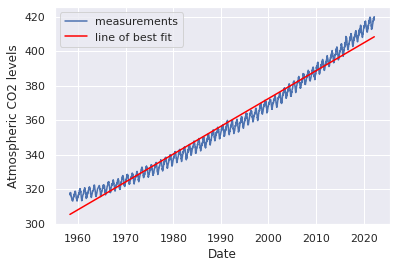

In [9]:
c0 = samples['c0'].mean()
c1 = samples['c1'].mean()

linear_approx = c0 + c1*df.time.values

plt.figure()
plt.plot(df.Date, df.CO2, label = 'measurements')
plt.plot(df.Date,linear_approx, 'Red', label = 'line of best fit')
plt.xlabel("Date")
plt.ylabel('Atmospheric CO2 levels')
plt.legend()
plt.savefig('fig2.png')
plt.show()

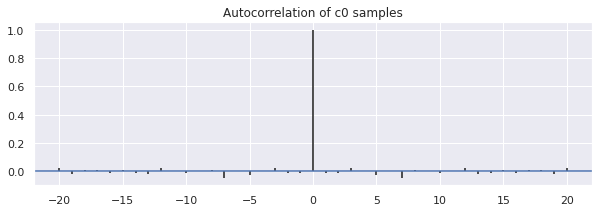

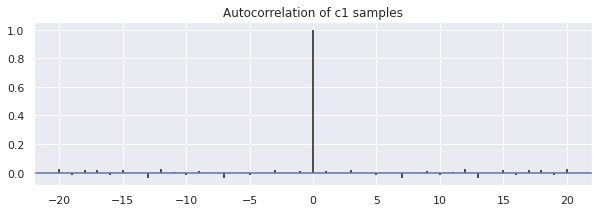

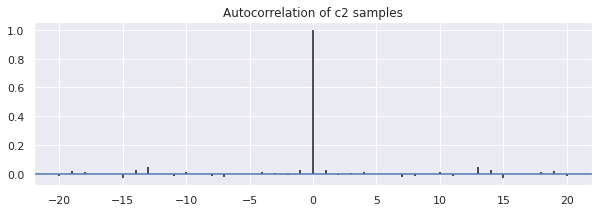

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


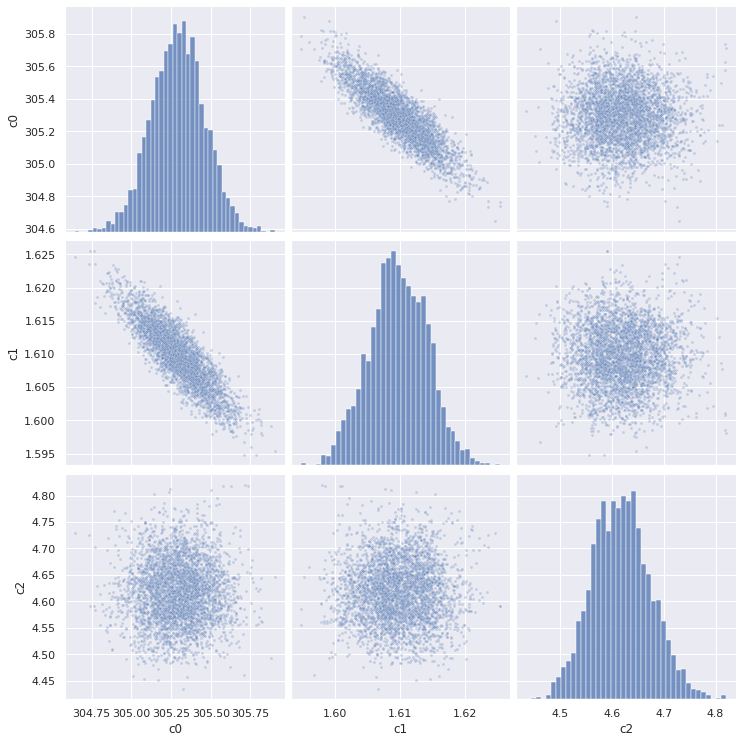

In [10]:
# Plot autocorrelation and pairwise plots
params = ['c0', 'c1', 'c2']
acf_plots(samples, params)
pair_plots(samples, params)

# Long Term Trend - Quadratic Model


In [41]:
stan_code2 = """
data {
    int<lower=0> len_data;             
    real<lower=0> date[len_data];      
    real measurements[len_data];               
}

parameters {
    real<lower=0> c;  
    real<lower=0> a;  
    real<lower=0> b;  
    real<lower=0> noise;        
} 

model {
 
    // Priors
    c ~ cauchy(310, 30);       
    a ~ normal(1,5);          
    b ~ normal(0,5);          
    noise ~ normal(0,2);      

    for (i in 1:len_data) {
        measurements[i] ~ normal(a*date[i]^2+b*date[i]+c, noise); 
    }
}

"""

In [42]:
# implement the model
model2 = pystan.StanModel(model_code=stan_code2)

# generate posterior
results = model2.sampling(data=stan_data)

#extract samples
samples = results.extract()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_940b06bafb8e7f248142434a8f483f55 NOW.


In [43]:
print(results.stansummary())

Inference for Stan model: anon_model_940b06bafb8e7f248142434a8f483f55.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c     314.75  3.3e-3   0.12 314.52 314.67 314.75 314.84 314.99   1371   1.01
a       0.01  3.8e-6 1.3e-4   0.01   0.01   0.01   0.01   0.01   1129    1.0
b       0.75  2.6e-4 8.5e-3   0.73   0.74   0.75   0.75   0.76   1102    1.0
noise   2.25  7.0e-4   0.03    2.2   2.23   2.25   2.27   2.31   1550    1.0
lp__   -4283    0.04   1.43  -4287  -4284  -4283  -4282  -4282   1117    1.0

Samples were drawn using NUTS at Fri Apr 22 01:38:41 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


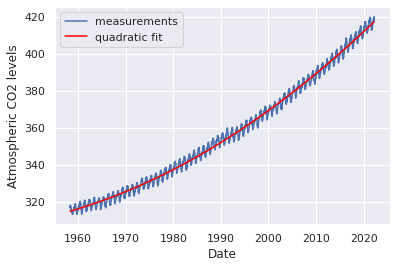

In [44]:
a = samples['a'].mean()
b = samples['b'].mean()
c = samples['c'].mean()

quadratic_fit = a*df.time.values**2 + b*df.time.values + c

plt.figure()
plt.plot(df.Date, df.CO2, label = 'measurements')
plt.plot(df.Date, quadratic_fit, 'Red', label = 'quadratic fit')
plt.xlabel("Date")
plt.ylabel('Atmospheric CO2 levels')
plt.legend()
plt.savefig('fig3.png')
plt.show()

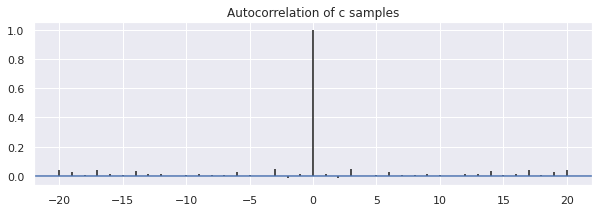

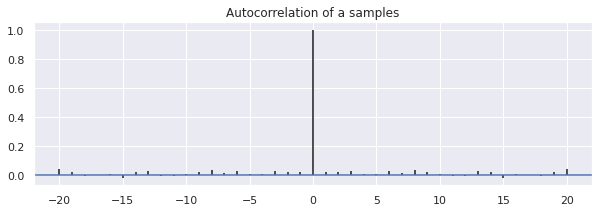

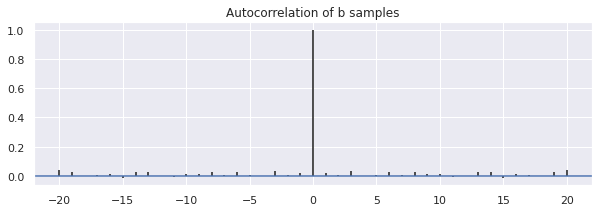

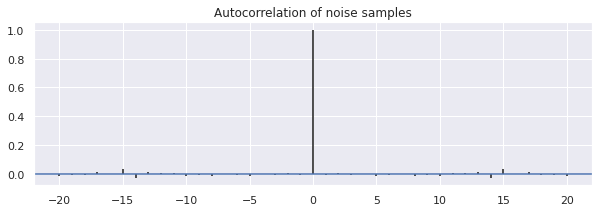

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


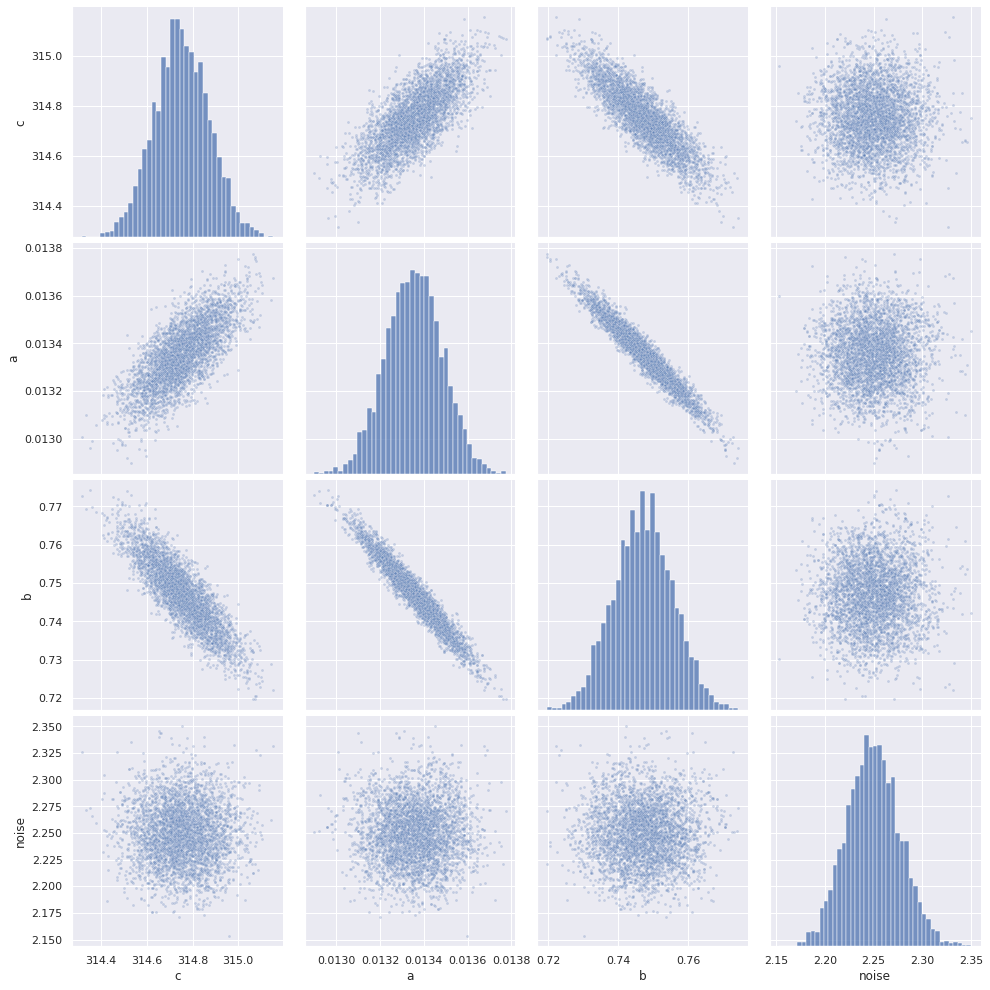

In [45]:
# Plot autocorrelation and pairwise plots
params = ['c', 'a', 'b', 'noise']
acf_plots(samples, params)
pair_plots(samples, params)


# Seasonal Variation

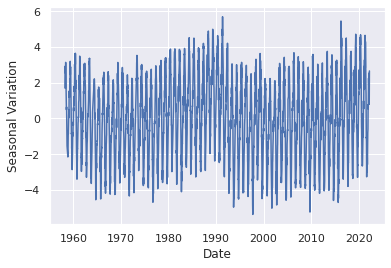

In [46]:
df['Seasonal'] = df.CO2 - quadratic_fit

plt.figure()
plt.plot(df.Date, df.Seasonal)
plt.xlabel('Date')
plt.ylabel('Seasonal Variation')
plt.savefig('fig4.png')
plt.show()

In [48]:
stan_code3 = """
data {
    int<lower=0> len_data;             
    real<lower=0> date[len_data];      
    real measurements[len_data];               
    real<lower=0> t_pi;
    
}

parameters {
    real<lower=0> A;  
    real<lower=0> noise;        

    real phi_x;            
    real phi_y;           

} 


transformed parameters {
    real phi = atan2(phi_x ,phi_y) ;   
                                        
}

model {
 
    // Priors
    phi_x ~ normal(0, 1);         
    phi_y ~ normal(0, 1);         
    A ~ inv_gamma(4, 1);            
    noise ~ normal(0,2);  

    // Likelihood
    for (i in 1:len_data) {
        measurements[i] ~ normal(A*cos(t_pi*date[i]+phi), noise); 
    }
}

"""

In [49]:
# set the data to be used by stan
stan_data = {
    "len_data" : len(df),
    "date" : df.time.values,
    "measurements" : df.Seasonal.values,
    "t_pi" : 2*np.pi
}

# implement the model
model3 = pystan.StanModel(model_code=stan_code3)

# generate posterior
results = model3.sampling(data=stan_data)

#extract samples
samples = results.extract()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fd6224c8c212d22dae2a03981f676853 NOW.


In [50]:
print(results.stansummary())

Inference for Stan model: anon_model_fd6224c8c212d22dae2a03981f676853.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
A       2.86  7.8e-4   0.02   2.81   2.84   2.86   2.88   2.91   1013    1.0
noise   0.99  6.5e-4   0.01   0.96   0.98   0.99   0.99   1.01    390    1.0
phi_x  -0.39    0.01   0.18  -0.78   -0.5  -0.37  -0.26  -0.11    190   1.03
phi_y   1.32    0.04   0.61   0.37   0.87   1.24   1.71   2.68    191   1.03
phi    -0.29  1.7e-4 8.6e-3  -0.31  -0.29  -0.29  -0.28  -0.27   2664    1.0
lp__   -1592    0.07   1.65  -1596  -1592  -1591  -1590  -1589    490   1.01

Samples were drawn using NUTS at Fri Apr 22 01:44:52 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


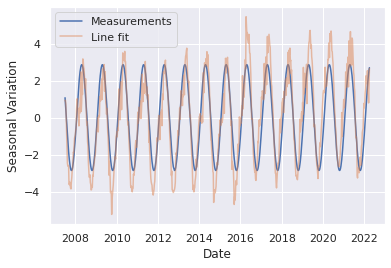

In [51]:
cos_seasonal_line = results['A'].mean()*np.cos(2*np.pi*df.time.values+results['phi'].mean())

plt.figure()
plt.plot(df.Date[2500:], cos_seasonal_line[2500:], label="Measurements")
plt.plot(df.Date[2500:], df.Seasonal[2500:],alpha=0.5, label="Line fit")
plt.xlabel("Date")
plt.ylabel('Seasonal Variation')
plt.legend()
plt.savefig('fig5.png')
plt.show()
plt.show()

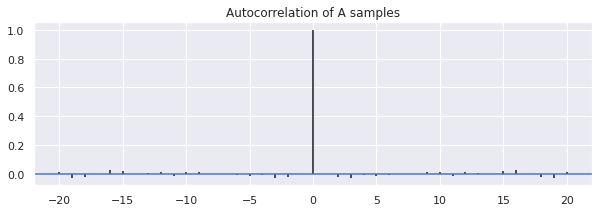

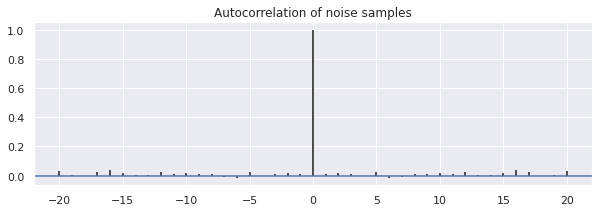

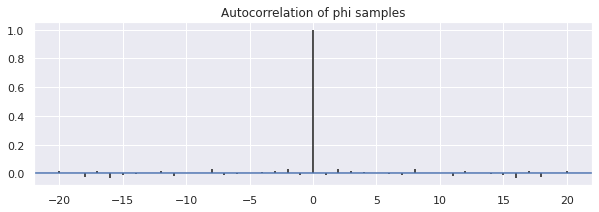

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


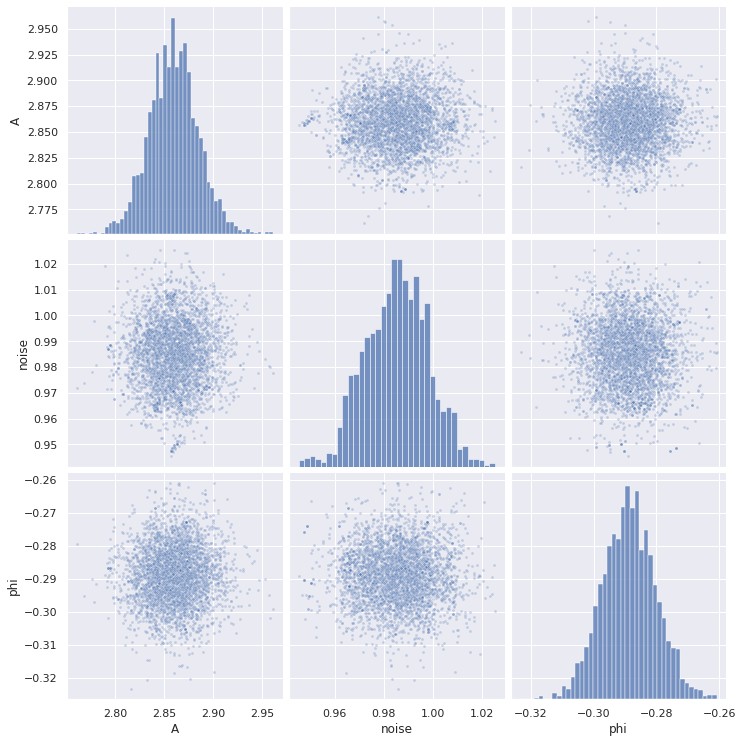

In [52]:
# Plot autocorrelation and pairwise plots
params = ['A', 'noise', 'phi']
acf_plots(samples, params)
pair_plots(samples, params)

# Predictive Model


In [53]:
# find prediction values in datetime format
prediction_dates = pd.date_range("2022-04-02", "2060-01-01", freq='W-FRI')
prediction_times = (prediction_dates - df.Date[0]).days / 365.25

In [55]:
stan_code4 = """
data {
    int<lower=0> len_data;             
    real<lower=0> date[len_data];      
    real measurements[len_data];               
    real<lower=0> t_pi;
    
    int<lower=0> total_future; 
    real<lower=0> future_date[total_future];
}

parameters {

    real<lower=0> a;  
    real<lower=0> b; 
    real<lower=0> c;

    real<lower=0> A;  
    real phi_x;            
    real phi_y;           
    real<lower=0> noise;        

} 


transformed parameters {
    real phi = atan2(phi_x ,phi_y) ;   
                                        
}

model {
 
    // Priors for Long Term trend
    a ~ normal(1,5);          
    b ~ normal(0,5);
    c ~ cauchy(310, 30);       

    // Priors for Seasonal Variation
    phi_x ~ normal(0, 1);         
    phi_y ~ normal(0, 1);         
    A ~ inv_gamma(4, 1);

    noise ~ normal(0,2);

    // Likelihood function
    for (i in 1:len_data) {
        measurements[i] ~ normal(a*date[i]^2 + b*date[i] + c + A*cos(t_pi*date[i]+phi), noise); 
    }
}

// Generate the predicted function values.
generated quantities {
    real x_future[total_future];
    for(i in 1:total_future) {
        x_future[i] = normal_rng(
            a*future_date[i]^2+b*future_date[i]+c+A*cos(t_pi*future_date[i]+phi), noise
            );
    }
}
"""

In [56]:
# set the data to be used by stan
stan_data = {
    "len_data" : len(df),
    "date" : df.time.values,
    "measurements" : df.CO2,
    "t_pi" : 2*np.pi,
    "total_future" : len(prediction_times),
    "future_date" : prediction_times
}

# implement the model
model4 = pystan.StanModel(model_code=stan_code4)

# generate posterior
results = model4.sampling(data=stan_data)

#extract samples
samples = results.extract()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d1b33f7a478165565edc26a820a342ea NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [57]:
print(results.stansummary())

Inference for Stan model: anon_model_d1b33f7a478165565edc26a820a342ea.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a                0.01  1.3e-6 5.6e-5   0.01   0.01   0.01   0.01   0.01   1808   1.01
b                0.75  8.8e-5 3.8e-3   0.74   0.74   0.75   0.75   0.75   1810   1.01
c              314.77  1.2e-3   0.05 314.67 314.74 314.77 314.81 314.88   2056    1.0
A                2.86  4.8e-4   0.02   2.81   2.84   2.86   2.88   2.91   2507    1.0
phi_x           -0.36  5.6e-3   0.18  -0.77  -0.48  -0.34  -0.23   -0.1    984    1.0
phi_y            1.22    0.02   0.59   0.33   0.77   1.13    1.6    2.6    985    1.0
noise            0.99  2.5e-4   0.01   0.96   0.98   0.99   0.99   1.01   2355    1.0
phi             -0.29  1.3e-4 8.4e-3  -0.31  -0.29  -0.29  -0.28  -0.27   4066    1.0
x_future[1]    420.07    0.02   0.99 

In [62]:
a = samples['a'].mean()
b = samples['b'].mean()
c = samples['c'].mean()
A = samples['A'].mean()
phi = samples['phi'].mean()

predic = a*df.time.values**2 + b*df.time.values + c +A * np.cos((2 *np.pi *df.time.values)+phi)


In [63]:
#get the mean predictions from our samples
predictions = []
for i in range(len(prediction_times)):
  sum1 = 0
  for j in range(1000):
    sum1+= samples['x_future'][j][i]
  predictions.append(sum1/1000)

# confidence intervals
lower = []
upper = []
for i in range(len(prediction_times)):
  temp = []
  for j in range(1000):
    temp.append(samples['x_future'][j][i])
  lower.append(np.percentile(temp, 2.5))
  upper.append(np.percentile(temp, 97.5))

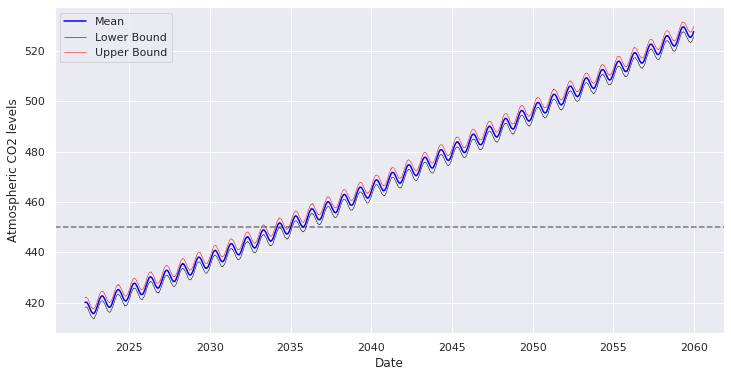

In [64]:
plt.figure(figsize=(12,6))
plt.plot(prediction_dates,predictions, color = 'blue', label = 'Mean')
plt.plot(prediction_dates,lower, color = 'black', linewidth = 0.5, label = 'Lower Bound')
plt.plot(prediction_dates, upper, color = 'red', linewidth = 0.5, label = 'Upper Bound')
plt.axhline(450, color = 'black',alpha=0.5,ls='dashed')
plt.legend()
plt.xlabel("Date")
plt.ylabel('Atmospheric CO2 levels')
plt.savefig('fig6.png')
plt.show()

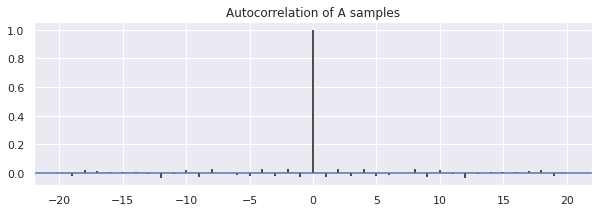

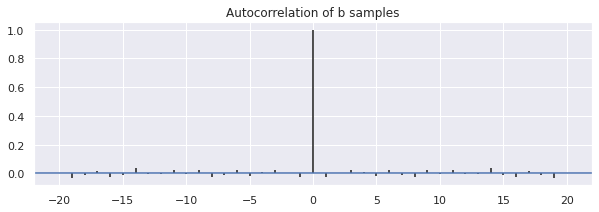

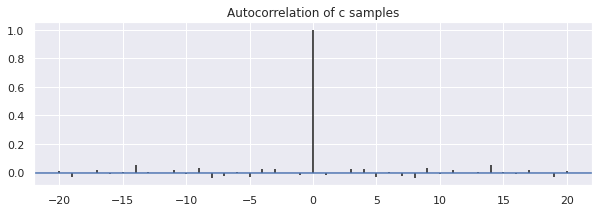

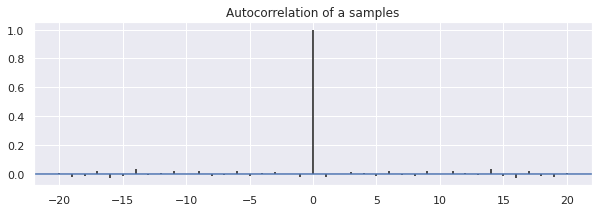

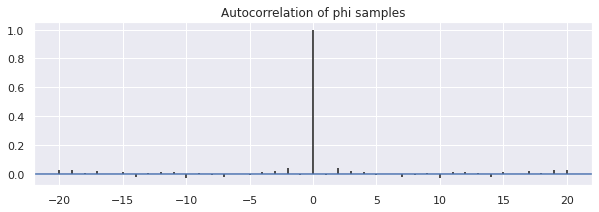

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


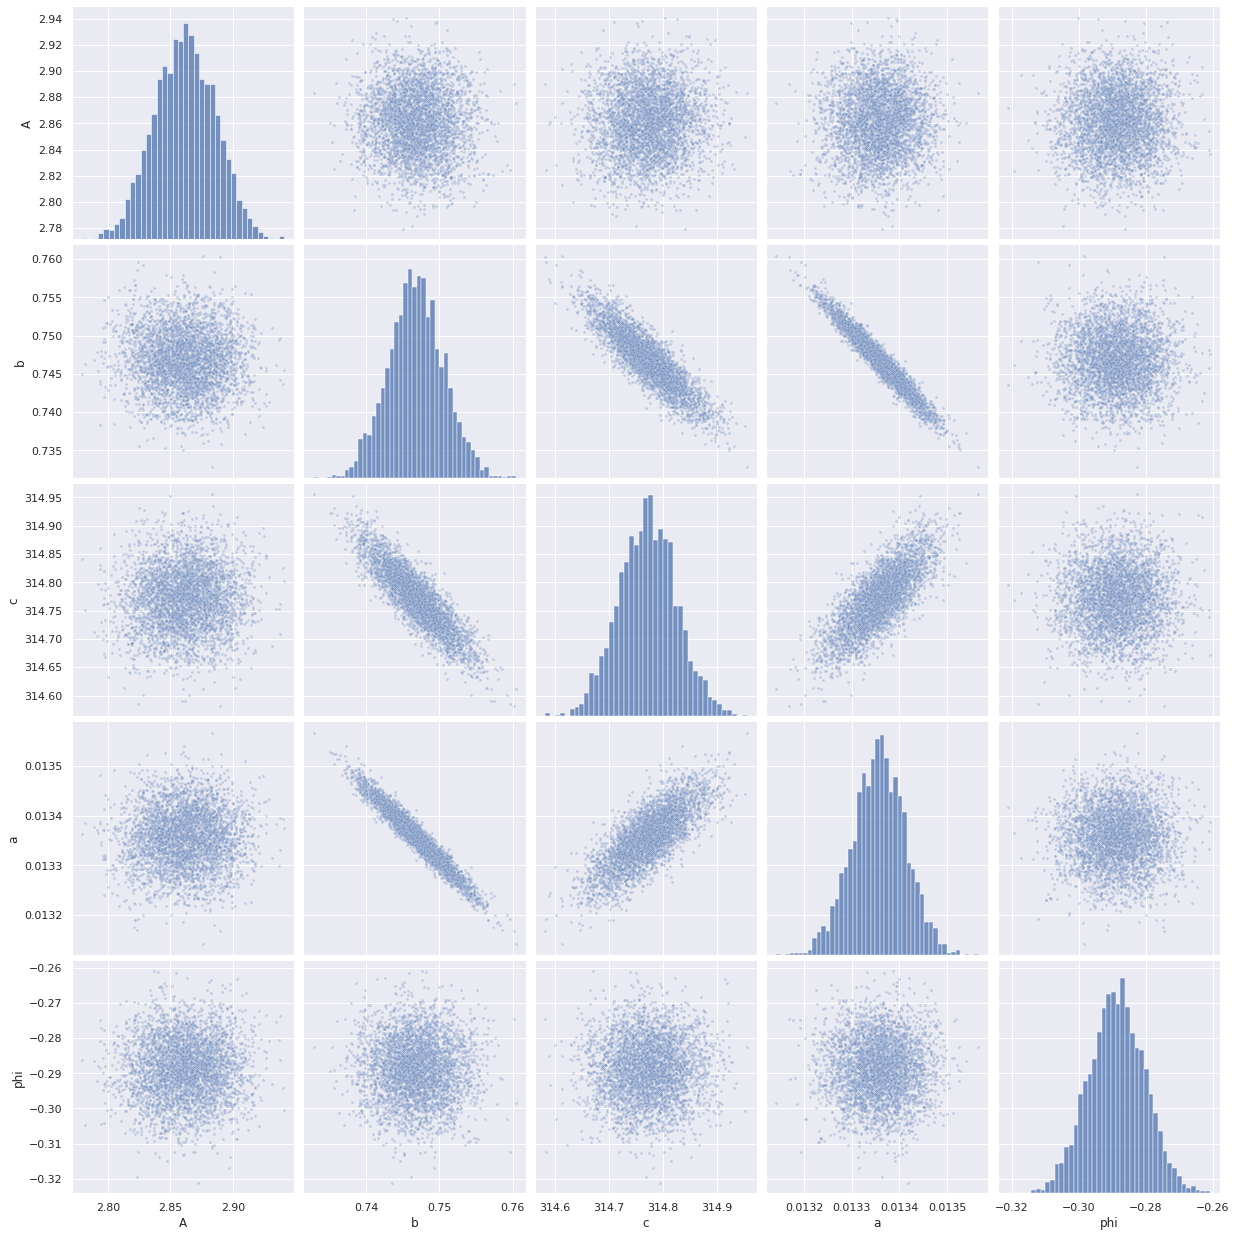

In [65]:
# Plot autocorrelation and pairwise plots
params = ['A', 'b', 'c', 'a', 'phi']
acf_plots(samples, params)
pair_plots(samples, params)

In [66]:
# PPM treshold reached
print(prediction_dates[621])
print(predictions[621])

2034-03-03 00:00:00
450.3020679884276


In [67]:
#finds the earliest when PPM will be reached
earliest = []
for i in range(len(lower)):
  if upper[i] >= 450.00:
    earliest.append(i)

prediction_dates[sorted(earliest)[0]]

Timestamp('2033-03-18 00:00:00', freq='W-FRI')

In [68]:
# finds the latests when PPM will be reached
latest = []
for i in range(len(lower)):
  if lower[i] >= 450.00:
    latest.append(i)

prediction_dates[sorted(earliest)[0]]

Timestamp('2033-03-18 00:00:00', freq='W-FRI')

In [69]:
# predictions for 2060
print(prediction_dates[-1])
print('Lower bound:', lower[-1])
print('Mean:', predictions[-1])
print('Upper bound:', upper[-1])

2059-12-26 00:00:00
Lower bound: 525.6569793182016
Mean: 527.693542911469
Upper bound: 529.7482380503271


# Test Statistics

In [70]:
generated = [[] for i in range(4000)]
def gen_samples(store, samples):    
    for i in range(4000):        
        for t in df['time']:
            store[i].append(sts.norm.rvs(samples['a'][i]*t**2 + samples['b'][i]*t + samples['c'][i] + \
                                 samples['A'][i]*np.cos(2*np.pi*t + samples['phi'][i])  \
                                 , samples['noise'][i]))
    return generated

In [71]:
generated_samples = gen_samples(generated, samples)

In [72]:
# Test statistic for the Mean
mean_test = []
count = 0
for i in range(len(generated_samples)):
  mean_test.append(np.mean(generated_samples[i]))
  if np.mean(generated_samples[i]) > np.mean(df.CO2):
    count += 1
mean_p= count/len(generated_samples)

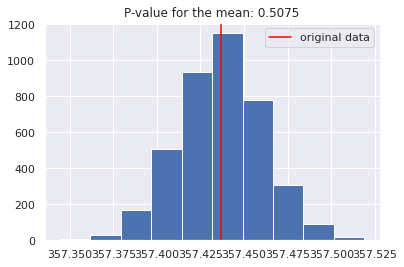

In [73]:
plt.figure()
plt.hist(mean_test)
plt.title('P-value for the mean: ' +str(mean_p))
plt.axvline(np.mean(df.CO2), color = 'red', label='original data')
plt.legend()
plt.savefig('fig7.png')
plt.show()

In [74]:
# Test statistic for Standard Deviation
stand_dev = []
count = 0
for i in range(len(generated_samples)):
  stand_dev.append(np.std(generated_samples[i]))
  if np.std(generated_samples[i]) > np.std(df.CO2):
    count += 1
sd_p= count/len(generated_samples)

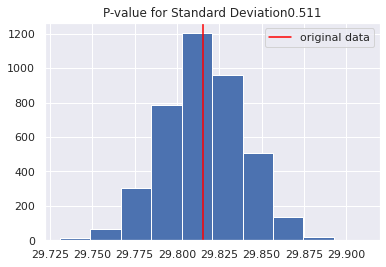

In [75]:
plt.figure()
plt.hist(stand_dev)
plt.title('P-value for Standard Deviation'+str(sd_p))
plt.axvline(np.std(df.CO2), color='red', label = 'original data')
plt.legend()
plt.savefig('fig8.png')
plt.show()